# Multi-Layer Perceptron Training 
Run imports cell, may need to downgrade (uninstall then reinstall at specific version) scikit-learn to 1.5.2 (run "pip install scikit-learn==1.5.2" in your terminal, then restart the kernel). \
\
**More robust model below!**

## Simple Grid Search CV 

In [14]:
# Imports 
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, roc_auc_score

In [5]:
# Load and preprocess data 
df = pd.read_csv("CLEANED_WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop("customerID", axis = 1)

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Ordinal encode "Contract" column 
contract_map = {"Month-to-month": 1, "One year": 2, "Two year": 3}
df["Contract"] = df["Contract"].map(contract_map)

# One-hot encode remaining categorical columns 
categorical_cols = df.select_dtypes(include = ["object"]).columns.tolist()
df = pd.get_dummies(df, columns = categorical_cols, drop_first = True)

# Split and initalize predictor features and target feature 
X = df.drop("Churn", axis = 1).values
y = df["Churn"].values

# Create train-test split (75:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

# Scale 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define create_model function for Keras Classifier 
def create_model(num_layers = 1, num_neurons = 32, activation = "relu", dropout_rate = 0.0, momentum = 0.0):
    model = Sequential()

    # Input and first hidden layer 
    model.add(Dense(num_neurons, activation = activation, input_shape = (X_train.shape[1],)))
    model.add(Dropout(dropout_rate))

    # Extra layers
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation = activation))
        model.add(Dropout(dropout_rate))

    # Output layer 
    model.add(Dense(1, activation = "sigmoid"))
    opt = SGD(learning_rate = 0.01, momentum = momentum)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model

# Define parameters grid for grid search
param_grid = {
    "model__num_layers": [3],
    "model__num_neurons": [32, 64],
    "model__activation": ["relu", "tanh"],
    "model__dropout_rate": [0.2, 0.5],
    "model__momentum": [0.5, 0.9]
}

# Create KerasClassifier wrapper 
model = KerasClassifier(
    model = create_model,
    epochs = 10, 
    batch_size = 32,
    verbose = 0,
    random_state = 42
)

# Perform grid search with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Record and print results 
records = []
for mean, std, params in zip(
        grid_search.cv_results_["mean_test_score"],
        grid_search.cv_results_["std_test_score"],
        grid_search.cv_results_["params"]):
    rec = {
        "accuracy": mean,
        "std_dev": std
    }
    for k, v in params.items():
        rec[k.replace("model__", "")] = v
    records.append(rec)

df_results = pd.DataFrame(records)
df_results = df_results.sort_values("accuracy", ascending = False).reset_index(drop = True)

print(df_results)




/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-22 18:27:32.893970: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attrib

Best: 0.804321 using {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.789152 (0.008018) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__momentum': 0.5, 'model__num_layers': 3, 'model__num_neurons': 32}
0.797116 (0.010797) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__momentum': 0.5, 'model__num_layers': 3, 'model__num_neurons': 64}
0.796736 (0.011644) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 32}
0.804321 (0.011058) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.769055 (0.011432) with: {'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__momentum': 0.5, 'model__num_layers': 3, 'model__num_neurons': 32}
0.793134 (0.011488) with: {'model__activation': 'relu', '

## More Robust Version 
Added ROC Curve, used stratified K-Fold, added learning rate and batch size to parameter grid, increased number of epochs, added early stopping in case of overfitting with increased training. 

In [21]:
# Additional imports 

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix 
from tensorflow.keras.callbacks import EarlyStopping

/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model inst

Best CV accuracy: 0.7526
Best parameters:  {'fit__batch_size': 32, 'fit__epochs': 50, 'model__activation': 'tanh', 'model__dropout_rate': 0.0, 'model__learning_rate': 0.01, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 32}
All CV results:
0.7330 +/- 0.0010    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7330 +/- 0.0046    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7370 +/- 0.0042    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7400 +/- 0.0061    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7308 +/- 0.0033    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3

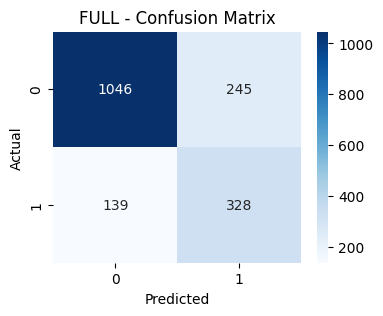

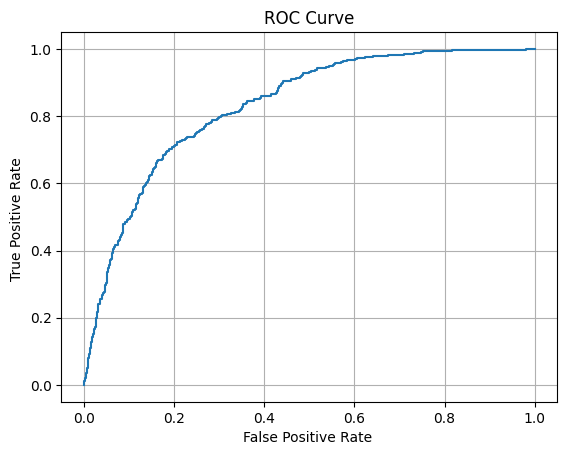

/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model inst

Best CV accuracy: 0.7516
Best parameters:  {'fit__batch_size': 32, 'fit__epochs': 50, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__learning_rate': 0.001, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 32}
All CV results:
0.7330 +/- 0.0073    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7330 +/- 0.0034    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7374 +/- 0.0080    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7433 +/- 0.0095    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 3, 'model__num_neurons': 64}
0.7234 +/- 0.0111    {'model__activation': 'tanh', 'model__dropout_rate': 0.5, 'model__momentum': 0.9, 'model__num_layers': 

/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ashtonlee/Desktop/STA 141C/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

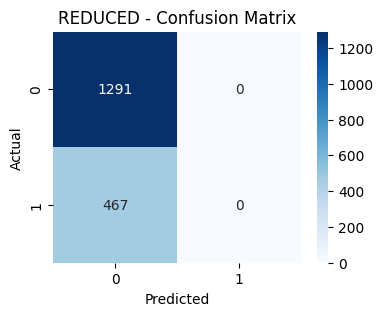

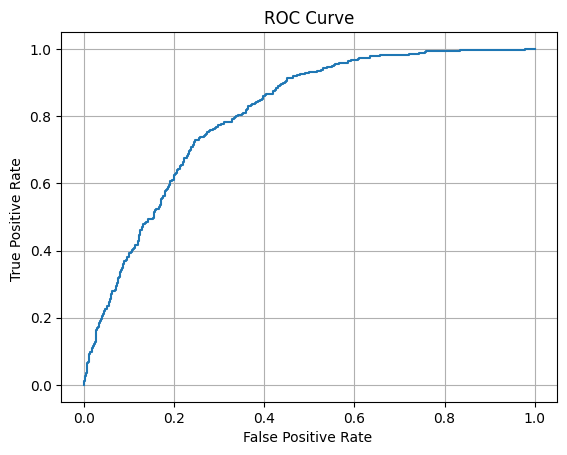

In [22]:
# Set seeds for tensorflow random ops 
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

def run_churn_pipeline(df, label = "FULL"):
    # Copy dataframe to operate on and encode "Churn" column 
    df = df.copy()
    df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
    # Ordinal encode "Contract" column 
    contract_map = {"Month-to-month": 1, "One year": 2, "Two year": 3}
    df["Contract"] = df["Contract"].map(contract_map)

    # One-hot encode remaining categorical columns 
    categorical_cols = df.select_dtypes("object").columns
    df = pd.get_dummies(df, columns = categorical_cols, drop_first = True)

    # Split and initalize predictor features and target feature 
    X = df.drop("Churn", axis = 1).values
    y = df["Churn"].values

    # Create train-test split (75:25)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size = 0.25, 
        random_state = 42, 
        stratify = y
    )

    # Scale 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define create_model function for Keras Classifier 
    def create_model(
            num_layers = 1, 
            num_neurons = 32, 
            activation = "relu", 
            dropout_rate = 0.0, 
            learning_rate = 0.01,
            momentum = 0.0):
        model = Sequential()

        # Input and first hidden layer 
        model.add(Dense(num_neurons, activation = activation, input_shape = (X_train.shape[1],)))
        model.add(Dropout(dropout_rate))

        # Extra layers
        for _ in range(num_layers - 1):
            model.add(Dense(num_neurons, activation = activation))
            model.add(Dropout(dropout_rate))

        # Output layer 
        model.add(Dense(1, activation = "sigmoid"))
        opt = SGD(learning_rate = 0.01, momentum = momentum)
        model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
        return model

    early_stop = EarlyStopping(
        monitor = "val_loss", 
        patience = 5, 
        restore_best_weights = True
    )

    # Define parameters grid for grid search
    param_grid = {
        "model__num_layers": [3],
        "model__num_neurons": [32, 64],
        "model__activation": ["relu", "tanh"],
        "model__dropout_rate": [0.0, 0.2],
        "model__learning_rate": [0.01, 0.001],
        "model__momentum": [0.0, 0.9],
        "fit__batch_size": [32, 64],
        "fit__epochs": [50]
    }

    # Initialize KerasClassifier wrapper 
    keras_clf = KerasClassifier(
        model = create_model, 
        verbose = 0,
        validation_split = 0.1,
        callbacks = [early_stop]
    )

    # Stratified KFold to minimize bias
    skf = StratifiedKFold(
        n_splits = 5,
        shuffle = True,
        random_state = 42
    )

    # Grid search
    grid = GridSearchCV(
        estimator = keras_clf,
        param_grid = param_grid,
        scoring = "accuracy",
        cv = skf,
        n_jobs = -1,
        return_train_score = False
    )
    grid_result = grid.fit(X_train, y_train)

    # Summarize CV results
    print(f"Best CV accuracy: {grid_result.best_score_:.4f}")
    print("Best parameters: ", grid_result.best_params_)
    print("All CV results:")
    for mean, std, parms in zip(
            grid_result.cv_results_["mean_test_score"],
            grid_result.cv_results_["std_test_score"],
            grid_result.cv_results_["params"]):
        print(f"{mean:.4f} +/- {std:.4f}    {params}")

    # Final evaluation on test set 
    best = grid_result.best_estimator_
    test_acc = best.score(X_test, y_test)
    y_pred = best.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred)

    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"\nTest ROC AUC: {test_auc:.4f}")
    print("\nClassification report on test set:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (4, 3))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
    plt.title(f"{label} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve plot 
    y_proba = best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate ")
    plt.ylabel("True Positive Rate ")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.show()

# Run on full dataset 
df_full = pd.read_csv("CLEANED_WA_Fn-UseC_-Telco-Customer-Churn.csv")
run_churn_pipeline(df_full, label = "FULL")

# Run on reduced dataset
df_reduced = df_full.drop(columns = ["TotalCharges", "gender", "PhoneService"])
run_churn_pipeline(df_reduced, label = "REDUCED")

Reduced model is only predicting "No", should add back variables, change scoring metric (possibly to optimize for AUC scoring), or use class weights. 